In [41]:
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
import numpy as np

In [22]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from train import save_model, train, get_classifier, evaluate
from model import NNModel
from logit_dataset import LogitDataset

## train

In [52]:
# 527-dim logits
clf = get_classifier(527)

In [53]:
from nt_paths import db_root, json_root
from logit_dataset import prepare_datasets

target_embedding_db_path = db_root + "/logits/esc50_ensemble_logits_full/database.json"
target_db_path = json_root + "/esc50_32khz.json"
validation_fold = 1
train_ds, validate_ds = prepare_datasets(validation_fold=validation_fold,
                                                db_path=target_db_path,
                                                embedding_db_path=target_embedding_db_path
db = LogitDataset(train_ds['logits'], validate_ds['logits'])

In [54]:
db.num_train_samples

17535

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:25<00:00, 15.82it/s]


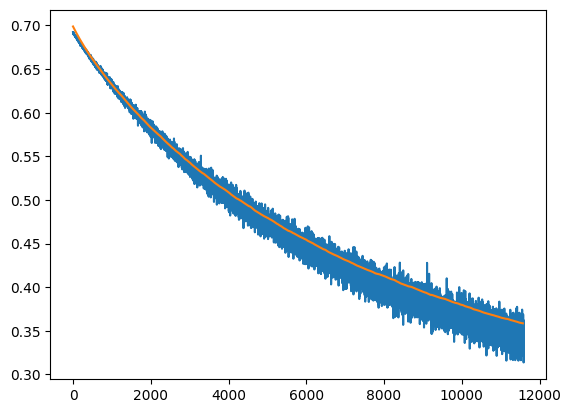

In [55]:
batch_size = 600
clf, train_losses, validate_losses = train(clf,
                                           db,
                                           mixup=2,
                                            batch_size=batch_size,
                                            epochs=400,
                                            lr=1e-4)
epoch_len = db.num_train_samples // batch_size
train_x = range(len(train_losses))
validate_x = epoch_len*np.arange(len(train_losses)//epoch_len)
plt.plot(train_x, train_losses, label='train loss')
plt.plot(validate_x, validate_losses, label='validate_loss')

## eval

In [3]:
# clf = joblib.load("/net/vol/werning/old_storage/relabel_model/domain_classifier3/model.joblib").clf

/net/home/werning/projects/msm-mae/msm-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [56]:
clf = clf.cuda()
model = NNModel(clf, 0.5)

In [57]:
res = evaluate(model, db)
pprint(res['confusion'])
pprint(res['class_weighted_confusion'])
print(f"precision: {100*res['weighted_precision']:0.1f}%")
print(f"recall: {100*res['weighted_recall']:0.1f}%")

          true  false
positive   373    528
negative  3406     27
              true     false
positive  0.932500  0.134215
negative  0.865785  0.067500
precision: 87.4%
recall: 93.2%


In [59]:
joblib.dump(model, "/net/vol/werning/storage/relabel_model/domain_classifier/model_5.joblib")

['/net/vol/werning/storage/relabel_model/domain_classifier/model_5.joblib']